In [1]:
import requests
from urllib.parse import urlencode
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse as ph
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm

plt.style.use('ggplot')

In [2]:
# настройки размеров графиков
sns.set(font_scale=2,
        style="whitegrid",
        rc={'figure.figsize': (20, 7)})

## Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла.

Далее мы прочитаем эти данные и сохраним в DataFrame

In [3]:
# Общая ссылка для чтения с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

#### groups.csv  
файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [4]:
# Cсылка для чтения
public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'  # Сюда пишется ссылка на Я.диск

# Получаем загрузочную ссылку
final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))
response_groups = requests.get(final_url_groups)
url_groups = response_groups.json()['href']

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
groups = pd.read_csv(url_groups, sep=';')

Посмотрим DataFrame: какие данные он содержит, его размер, типы данных, проверим его на наличие NaN и посмотрим число уникальных данных в столбцах

In [6]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [7]:
groups.shape

(74484, 2)

In [8]:
groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
groups.nunique()

id     74484
grp        2
dtype: int64

DataFrame содержит 74484 строки и уникальных значений id тоже 74484 - делаем вывод, что каждая строка в данном DataFrame содержит уникальный id.

Тестовых групп 2, как и указано в задании.

Пропусков в данных нет.

Так как DF содержит уникальные id в каждой строке, то нет необходимости проверять не попал ли в группу А и группу В один и тот же человек.

#### groups_add.csv 
дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [11]:
# Cсылка для чтения
public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  # Сюда пишется ссылка на Я.диск

# Получаем загрузочную ссылку
final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
response_groups_add = requests.get(final_url_groups_add)
url_groups_add = response_groups_add.json()['href']

In [12]:
groups_add = pd.read_csv(url_groups_add)

Посмотрим DataFrame: какие данные он содержит, его размер, типы данных, проверим его на наличие NaN и посмотрим число уникальных данных в столбцах

In [13]:
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [14]:
groups_add.shape

(92, 2)

In [15]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [16]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [17]:
groups_add.nunique()

id     92
grp     2
dtype: int64

DataFrame содержит 92 строки и уникальных значений id тоже 92 - делаем вывод, что каждая строка в данном DataFrame содержит уникальный id.

Тестовых групп 2, как и указано в задании.

Пропусков в данных нет.

Так как DF содержит уникальные id в каждой строке, то нет необходимости проверять не попал ли в группу А и группу В один и тот же человек.

Дополнительно необходимо проверить не пересекаются ли id в предыдущем DF с текущими id, т.к. типы данных для id в обоих DF одинаковые, то в дополнительных преобразованиях нет необходимости

In [18]:
gr = set(groups.id)
gr_add = set(groups_add.id)
gr_add.intersection(gr)

set()

По результатам проверки не было выявлено пересекающихся id в обоих DF

#### active_studs.csv 
файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [19]:
# Cсылка для чтения
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'  # Сюда пишется ссылка на Я.диск

# Получаем загрузочную ссылку
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
response_active_studs = requests.get(final_url_active_studs)
url_active_studs = response_active_studs.json()['href']

In [20]:
active_studs = pd.read_csv(url_active_studs)

Посмотрим DataFrame: какие данные он содержит, его размер, типы данных, проверим его на наличие NaN и посмотрим число уникальных данных в столбцах

In [21]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [22]:
active_studs.shape

(8341, 1)

In [23]:
active_studs.dtypes

student_id    int64
dtype: object

In [24]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [25]:
active_studs.nunique()

student_id    8341
dtype: int64

DataFrame содержит 8341 строку и уникальных значений id тоже 3841 - делаем вывод, что каждая строка в данном DataFrame содержит уникальный id.

Пропусков в данных нет.

id пользователя приведено к тому же типу данных, что и в других DF, в дополнительных преобразованиях нет необходимости

#### checks.csv 
файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [26]:
# Cсылка для чтения
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'  # Сюда пишется ссылка на Я.диск

# Получаем загрузочную ссылку
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
response_checks = requests.get(final_url_checks)
url_checks = response_checks.json()['href']

In [27]:
checks = pd.read_csv(url_checks, sep=';')

Посмотрим DataFrame: какие данные он содержит, его размер, типы данных, проверим его на наличие NaN и посмотрим число уникальных данных в столбцах

In [28]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [29]:
checks.shape

(541, 2)

In [30]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [31]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [32]:
checks.nunique()

student_id    541
rev            39
dtype: int64

DataFrame содержит 541 строку и уникальных значений id тоже 541 - делаем вывод, что каждая строка в данном DataFrame содержит уникальный id.

Пропусков в данных нет.

id пользователя приведено к тому же типу данных, что и в других DF, в дополнительных преобразованиях нет необходимости

Столбец rev - предположительно это Revenue соодержит числовые данные в формате float64 - данный формат подходит для вычислений,  в дополнительных преобразованиях нет необходимости

Дополнительно проверим, возможно ли такое, что человек совершил покупку, но при этом не проявлял активность в течении периода эксперимента

In [33]:
checks.query("student_id not in @active_studs.student_id")

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Как видно из запроса - возможна ситуация, когда человек не проявлял активность, но покупку совершил. Т.к. у нас нет возможности задать вопросы и уточнить как такое может быть и в чем специфика процесса, на основании которого мы получили эти данные, предлагаем просто в дальнейшем учитывать этот нюанс без более глубоких пояснений

Также необходимо сцепить два DF groups и groups_add. На данном этапе мы не можем выяснить почему DF был прислан позднее и повлияет ли это на эскперимент. При ознакомлении с данными не было выявлено никаких нестыковок, дублирований и отсутствующих данных. Также не было выявлено, что данные 2 DF критически отличаются друг от друга. id из дополнительного ДФ также имеются в других ДФ, а именно checks и active studs . Дополнительно я попыталась проанализировать DF по отдельности, но не выявила никаких явных различий, а также не хватает данных для того, чтобы понять равнозначны ли DF или нет. 

Поэтому мы принимаем решение объединить их в один.

In [34]:
groups_all = pd.concat([groups, groups_add], axis=0)

In [35]:
groups.shape[0] + groups_add.shape[0]  # проверяем не потерялись ли строки

74576

In [36]:
groups_all.shape

(74576, 2)

In [37]:
groups_all.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [38]:
groups_all.dtypes

id      int64
grp    object
dtype: object

Контрольная сумма по строкам сошлась, все типы данных на месте. Далее мы будем работать с объединенным DF

## 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:   
На какие метрики Вы смотрите в ходе анализа и почему?      
Имеются ли различия в показателях и с чем они могут быть связаны?      
Являются ли эти различия статистически значимыми?     
Стоит ли запускать новую механику на всех пользователей?       
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.     

### Метрики
В ходе исследования исходных данных были сделаны следующие заключения:     
- у нас есть информация о следующей воронке: регистрация (присвоение id) -> активность -> покупка;    
- есть информация о сумме покупок (выручке) с каждого покупателя;
- есть пользователи, которые не были активны в период эксперимента, но сделали покупку. Возможно, это был автоплатеж, для чистоты эксперимента предлагаем учитывать только пользователей, которые были активны в период проведения теста.

Исходя из информации, собранной выше, мной были отобраны две метрики:       
1 Конверсия пользователей, которые были активны в период проведения теста, в покупателя (относительная конверсия).     
2 ARPAU - средний доход с активного пользователя

Первая метрика была выбрана из предположения, что упрощение оплаты приведен к тому, что бОльшее количество человек будет оплачивать.
Вторая метрика была выбрана из предположения, что упрощение механики оплаты - увеличит число заказов у пользователя, соответственно, увеличится сумма его покупок. Т.к. у нас нет данных по количеству покупок, а также стоимости каждой покупки на пользователя, а дана только общая сумма покупок за весь период тестирования - единственное, что мы можем сравнить, это сумма покупок каждого пользателя в двух группах.

#### 1 Относительная конверсия   активных пользователей
(активность -> покупка)

In [39]:
# создаем столбец с фактом активности или ее отсутствием
groups_all['is_active'] = groups['id'].isin(active_studs.student_id).astype(int) 

In [40]:
# создаем столбец с фактом покупки или ее отсутствия (0 - нет покупок, 1 - есть покупки)
groups_all['is_purchase'] = groups_all['id'].isin(checks.student_id).astype(int) 

In [41]:
groups_all.head(3)

,id,grp,is_active,is_purchase
0,1489,B,0,0
1,1627,A,1,1
2,1768,B,0,0


In [42]:
# отберем только активных пользователей и посмотрим как выглядит общее соотношение в группах А и В
CR_relative = pd.crosstab(
    groups_all.query("is_active == 1").grp, 
    groups_all.query("is_active == 1").is_purchase
)
CR_relative

is_purchase,0,1
grp,,
A,1457,78
B,6485,313


In [43]:
CR_relative['CR_percent'] = (CR_relative[1] / CR_relative[0]) * 100  # вычислим значение конверсии для каждой группы
CR_relative

is_purchase,0,1,CR_percent
grp,,,
A,1457,78,5.353466
B,6485,313,4.826523


In [44]:
CR_relative.CR_percent.diff()  # разница между конверсиями в группе А и В

grp
A         NaN
B   -0.526943
Name: CR_percent, dtype: float64

Согласно расчетам конверсия в группе В также меньше, чем в групе A. Разница составляет примерно 0,53 %. Предположительно нововведение может оказать негативное влияние на данную метрику.

Проверим является ли это изменение статистически значимым.      
Так как при расчете метрики мы используем категориальные переменные - факт покупки и отношение к группе А или В, то мы воспользуемся тестом хи-квадрат. 

Сформируем гипотезы:     
H0 - В конверсии активного пользователя в покупателя ничего не изменилось, результат случайный.      
H1 - Изменение в конверсии активного пользователя в покупателя значимо, пользователи стали реже покупать.

Здесь и далее при проверке гипотез принимаем порог для отклонения нулевой гипотезы p-value=0.05 (5%)

In [45]:
exp, obs, stat = pg.chi2_independence(data=groups_all, x='grp', y='is_active')
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.644449,1.0,0.001899,0.011372,0.874017
1,cressie-read,0.666667,9.691328,1.0,0.001851,0.011400,0.875571
2,log-likelihood,0.000000,9.786809,1.0,0.001758,0.011456,0.878682
3,freeman-tukey,-0.500000,9.859957,1.0,0.001689,0.011498,0.881019
4,mod-log-likelihood,-1.000000,9.934452,1.0,0.001622,0.011542,0.883356
5,neyman,-2.000000,10.087589,1.0,0.001493,0.011630,0.888033


Данный тест подсчитывает хи квадрат несколькими вариантами. Как видно из результатов, все тесты примерно имеют один и тот же результат.    
Посмотрим на 2 показателя:   
1 pval - p-уровень значимости. Здесь он составляет примерно 0,0019 (0,19 %) - значение ниже порогового значения p-value принятого выше. Соответственно, у нас есть все основания отклонить нулевую гипотезу.   
2 cramer - вариант коэффициента корреляции. Чем ближе коэффциент к 1 - тем выше влияние. В данном случае значения очень небольшие, и ближе к 0, чем к единице. Очень низкий уровень корреляции данных.

#### Считаем, что с бОльшей вероятностью, изменения между группами А и В в части относительной конверсии статистически значимы. Также отметим негативный эффект в метрике относительной конверсии в части нововведений.

#### 2 ARPAU - средний доход с активного пользователя

Отберем только активных в период проведения теста пользователей, затем объединим ДФ с информацией об оплатах

In [46]:
checks_all = groups_all.query("is_active == 1")[['id', 'grp']] \
    .merge(checks, how='left', left_on='id', right_on='student_id') \
    .drop('student_id', axis=1).fillna(0)
checks_all.head(3)

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0


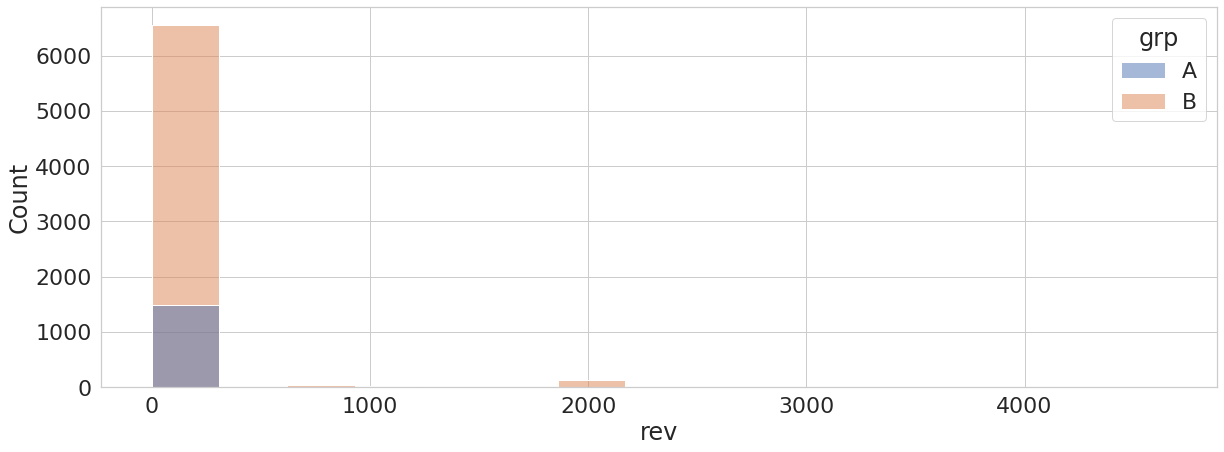

In [47]:
# визуализируем распределение суммы покупок на активного пользователя внутри групп
sns.histplot(data=checks_all, x='rev', hue='grp')

Как видно на визуализации данных - оба распределения не являются нормальными. 

Для более точного сравнения, посмотрим как изменился ARPAU в двух группах

In [48]:
# посчитаем ARPAU по группам 
ARPAU_all = checks_all.groupby('grp', as_index=False).agg(revenue=('rev', 'sum'), quantity=('id', 'count'))

In [49]:
ARPAU_all['ARPAU'] = ARPAU_all.revenue / ARPAU_all.quantity

In [50]:
ARPAU_all

,grp,revenue,quantity,ARPAU
0,A,72820.0000,1535,47.439739
1,B,393074.0035,6798,57.822007


In [51]:
ARPAU_percent = (ARPAU_all.ARPAU[1] - ARPAU_all.ARPAU[0]) / ARPAU_all.ARPAU[0] * 100
ARPAU_percent 

21.885169906043767

Мы видим, что ARPAU в тестовой группе В увеличился на 21,9 % в сравнении с ARPAU в контрольной группе А. Метрика изменилась в положительную сторону.

Проверим являются ли эти изменения статистически значимимыми.     
Исходя из того, что распределение ненормальное, а данные являются количественными для определения статистической значимости, а также принимая во внимание то, что мы сравниваем средние значения в двух группах в качестве теста будем использовать bootstrap.

In [52]:
df_contol = checks_all.query("grp == 'A'").rev
df_exp = checks_all.query("grp == 'B'").rev

Сформируем гипотезы:     
H0 - Статистически значимых различий между средними в обеих группах нет.      
H1 - Статистически значимые различия между средними в обеих группах есть.  

In [53]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
# Функция взята из лекций на курсе
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    '''бутстрапируем выборку и вычисляем разность интересующих параметров'''
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    '''Визуализация'''
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

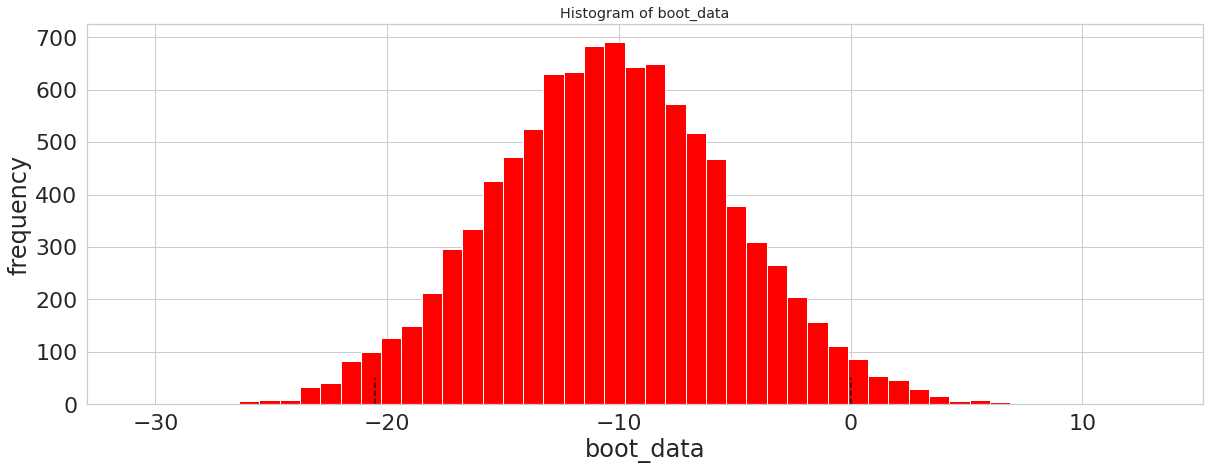

In [54]:
# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(df_contol, df_exp, boot_it=10000, statistic=np.mean, bootstrap_conf_level=0.95)

In [55]:
booted_data["p_value"]  # p-value

0.04668478126774109

In [56]:
booted_data["quants"]  # ДИ

,0
0.025,-20.523563
0.975,-0.000920


Как видно из исследования проведенного выше 0 находится ВНЕ доверительного интервала разницы средних внутри групп.   
pval - p-уровень значимости составляет примерно 0,044 (4,4 %) - значение ниже порогового значения p-value принятого выше. Соответственно, у нас есть все основания отклонить нулевую гипотезу.

#### Считаем, что с бОльшей вероятностью, изменения между группами А и В в части ARPPU статистически значимы. Также отметим положительный эффект в метрике ARPPU в части нововведений.

### Вывод к Заданию 1

Итак, при сравнении целевой группы В с контрольной группой А мы сделали следующие выводы:    
1 Конверсия пользователей, которые были активны в период проведения теста, в покупателя (относительная конверсия):     
    уменьшилась, тесты показывают, что изменения были статистически значимыми с бОльшей долей вероятности.   
        
2 ARPAU - средний доход с активного пользователя:
    увеличился, проведенный тест показал, что у нас есть основания утверждать, что произошедшие изменения были статистически значимыми с   бОльшей долей вероятности.
    
На данный момент, мы видим, что конверсия активного пользователя в покупателя статистически значимо уменьшилась, ARPAU увеличился в экспериментальной группе, при чем значение p-value при проведении теста для ARPPU было очень близко к пороговому значению p-value.        
Тем не менее, мы не можем сделать однозначный вывод несут ли изменения положительный эффект, имея только те данные, что у нас есть.

Во-первых, в результате ознакомления с исходными данными были выявлены некоторые вопросы, которые могут влиять на интерпретацию результатов, а именно:      
1 Дополнительный файл studs_add, присланный через 2 недели, вызывает опаснения тем, что прислан позднее и данная выборка может быть уже не репрезентативной в виду разных временных рамок исследования.     
2 Есть вопросы, связанные с тем, что пользователи не были активны, но совершали покупки. При каком развитии событий это могло произойти? Это автооплата или нет? Влияет ли это на интерпретацию наших результатов?      
3 Не до конца ясно, rev указанное в таблице checks это сумма покупок в результате однйо покупки или разных покупок пользователя? Сумма увеличилась потому что пользователям понравилась новая механика оформления заказа и они делали много покупок? Либо это была одна покупка на бОльшую сумму? 

Во-вторых, по результатам исследований было выявлено, что относительная конверсия из активности в покупку - отрицательная, а ARPAU положительный. Необходимо уточнить при каком развитии событий такое могло произойти? Не было ли проведения каких-то рекламных компаний как стимуляции покупок во время проведения эксперимента?Вопрос номер 3, указанный выше созвучен с данным пунктом и требует дополнительных исследований. 

В-третьих, необходимо обсуждения с коллегами, которые могут оценить целесообразно ли экономически потерять в относительной конверсии при условии увеличения ARPAU, при условии, что вопросы, указанные выше по итогу не оказали влияния на данные.

С учетом выше сказанного требуется дополнительная проработка данного исследования с учетом ответов на вопросы, указанные выше. Однозначного ответа пока нет.

## Задание 2. SQL

Для связи python и SQL будем использовать библиотеку Pandahouse. Перед тем как приступить к выполнению заданий, мной были исследованы данные в SQL.     
Были сделаны следующие выводы:    
- согласно датам, указанным в таблицах, данные предоставлены в рамках одного месяца. В заданиях есть условия по датам "за текущий месяц", и т.к. все данные даны за месяц, то мы не импортируем столбцы с датами, они не принимают участие в данном исследовании;
- столбцы с id студентов имеют одинаковый тип данных в различных ДФ и одинаковое название;
- стобец Money имеет формат int, что позволяет проводить с ним математические операции;
- пропущенные значения отсутствуют;
- в ДФ studs нет повторябщихся id_st, задвоения отсутствуют.

In [57]:
# параметры для подключения к CH и базе данных default
connection_default = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'default',
    'user': 'student', 
    'password': 'dpo_python_2020'
}

### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

#### 2.1.2 Задача

Дана таблица default.peas
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [58]:
q2_1 = '''
SELECT
    COUNT(*) AS rows
FROM (  
    SELECT
        st_id,
        sum(correct) AS quantity
    FROM
        peas
    GROUP BY 
        st_id
    HAVING
        quantity > 19
    )
    '''


# отправляем запрос и записываем результат в пандасовский датафрейм
answer2_1 = ph.read_clickhouse(query=q2_1, connection=connection_default).rows[0]

In [59]:
print(f'ОТВЕТ: Количество очень усердных студентов в таблице, решивших за месяц 20 и более задач - {answer2_1} человек')

ОТВЕТ: Количество очень усердных студентов в таблице, решивших за месяц 20 и более задач - 136 человек


####  2.2.2 Задача
Дана таблицы: default.peas (см. выше), default.studs и default.final_project_check.    
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:  
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Дополнительные условия для метрик:    
ARPU считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.       
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.    

Для решения данной задачи мы посчитаем в блоке WITH общее число участников эксперимента (как количество пользователей с уникальным st_id).
Затем:
- ARPU - средний доход с привлечённого пользователя внутри каждой группы считаем как соотношение суммы оплат внутри каждой тестовой группы к общему числу участников всего эксперимента. 
- ARPAU - средний доход с активного привлеченного пользователя внутри каждой тестовой группы считаем как как отношение суммы всех оплат активных участников внутри группы к общему числу активных участников внутри группы. При этом активным мы считаем пользователя, который решил больше 10 задач правильно в любых дисциплинах.
- CR в покупку - конверсию в покупку считаем как отношение числа всех пользователей, совершивших поокупку внутри группы к общему числу пользователей внутри группы.
- CR активного пользователя в покупку считаем также как CR в покупку, но только для активных пользователей. Активным мы считаем пользователя, который решил больше 10 задач правильно в любых дисциплинах. 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике - конверсия для активного пользователя предмета Математика. Считаем по формуле CR в покупку, но при двух дополнительных условиях: пользователь должен быть активен по предмету Математика (а значит решил 2 и более задачи по математике), а в сумму покупок бучитываются только покупки, связанные с предметом Математика.

Для удобства восприятия конверсия показана в процентном значении

In [60]:
# создаем запрос, database задана выше 'default'
q_metric = '''
WITH (SELECT COUNT(DISTINCT(st_id)) FROM studs) AS total_studs

SELECT 
    test_grp,
    
    sum(revenue_all) / total_studs AS ARPU,
    
    sum(CASE WHEN correct_all > 10 THEN revenue_all ELSE 0 END) / 
        sum(CASE WHEN correct_all > 10 THEN 1 ELSE 0 END) AS ARPAU, 
    
    (sum(CASE WHEN revenue_all > 0 THEN 1 ELSE 0 END) / 
        count(st_id)) * 100 AS CR_percent,
    
    (sum(CASE WHEN correct_all > 10 AND revenue_all > 0 THEN 1 ELSE 0 END) /
        sum(CASE WHEN  correct_all > 10  THEN 1 ELSE 0 END)) * 100 AS CR_active_percent, 
    
    (sum(CASE WHEN correct_math > 1 AND revenue_math > 0 THEN 1 ELSE 0 END) / 
        sum(CASE WHEN  correct_math > 1 THEN 1 ELSE 0 END)) * 100 AS CR_active_math_percent
FROM
    (
    SELECT
    test_grp,
    st_id,
    correct_all,
    correct_math,
    revenue_all,
    revenue_math
    FROM
        (
        SELECT
        st_id,
            SUM(money) AS revenue_all,
            SUM(CASE WHEN subject == 'Math' THEN money ELSE 0 END) AS revenue_math
        FROM 
            final_project_check
        GROUP BY
            st_id
        ) AS f
    RIGHT JOIN
        (
        SELECT
            st_id,
            test_grp,
            correct_all,
            correct_math    
        FROM 
            studs AS s
        LEFT JOIN 
            (SELECT
                st_id,
                SUM(correct) AS correct_all,
                SUM(CASE WHEN subject == 'Math' THEN correct ELSE 0 END) AS correct_math
            FROM
                peas
            GROUP BY
                st_id
            ) as p
        ON s.st_id = p.st_id
        ) AS sp
    ON f.st_id = sp.st_id
    )
GROUP BY test_grp
    '''


# отправляем запрос и записываем результат в пандасовский датафрейм
final_project_check = ph.read_clickhouse(query=q_metric, connection=connection_default)

In [61]:
final_project_check 

,test_grp,ARPU,ARPAU,CR_percent,CR_active_percent,CR_active_math_percent
0,control,2308.333333,10393.700787,4.918033,11.023622,6.122449
1,pilot,5658.333333,29739.583333,10.847458,26.041667,9.523810


## Задание 3. Python

### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.     

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [62]:
def metrics_update_studs_add(groups, active_studs, checks): 
    def get_data_metrics(groups, active_studs, checks):
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  # общая ссылка на Я.диск
        public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  # индивидуальная ссылка на файл
        # формируем загрузочную ссылку
        final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))  
        response_groups_add = requests.get(final_url_groups_add)
        url_groups_add = response_groups_add.json()['href']
        groups_add = pd.read_csv(url_groups_add)  # читаем ДФ
        
        '''объединяем ДФ с исходным ДФ 'groups', чтобы иметь полный список участников'''
        groups_full = pd.concat([groups, groups_add], axis=0)
        # определяем факт покупки для каждого
        groups_full['is_purchase'] = groups_full['id'].isin(checks.student_id).astype(int)
        # определяем фактом активности для каждого
        groups_full['is_active'] = groups['id'].isin(active_studs.student_id).astype(int) 
        # определяем кто был активен и купил
        groups_full['is_active_and_purchase'] = groups_full.is_purchase * groups_full.is_active  
        return groups_full
    
    def get_checks_full(groups_full):
        '''объединяем общий ДФ groups_full с ДФ checks. '''
        checks_full = groups_full.query("is_active == 1")[['id', 'grp']] \
            .merge(checks, how='left', left_on='id', right_on='student_id') \
            .drop('student_id', axis=1).fillna(0)
        return checks_full
            
    def CR_abs(groups_full):
        '''рассчитываем метрику 1 Абсолютная конверсия: регистрация (присвоение id) -> покупка'''
        CR_abs_full = pd.crosstab(groups_full.grp, groups_full.is_purchase)
        CR_abs_full['CR_percent'] = (CR_abs_full[1] / CR_abs_full[0]) * 100  
        return CR_abs_full

    def CR_abs_active(groups_full):
        '''
        рассчитываем метрику 2 Абсолютная конверсия: регистрация (присвоение id) -> покупка) при условии, 
        что пользователь в период эксперимента проявлял активность. Вычислим значение конверсии для каждой группы
        '''
        CR_abs_active_full = pd.crosstab(groups_full.grp, groups_full.is_active_and_purchase)
        CR_abs_active_full['CR_percent'] = (CR_abs_active_full[1] / CR_abs_active_full[0]) * 100  
        return CR_abs_active_full
        
    def CR_relative(groups_full):        
        '''рассчитываем метрику 3 Относительная конверсия (активность -> покупка)'''
        # отберем только тех, кто был активен и рассчитаем конверсию в покупку только среди них
        CR_relative_full = pd.crosstab(
            groups_full.query("is_active == 1").grp, 
            groups_full.query("is_active == 1").is_purchase
        ) 
        # вычислим значение конверсии для каждой группы
        CR_relative_full['CR_percent'] = (CR_relative_full[1] / CR_relative_full[0]) * 100  
        return CR_relative_full
        
    def ARPAU(checks_full):        
        '''рассчитываем метрику 4 - ARPAU средний доход на активного пользователя'''
        ARPAU_full = checks_full.groupby('grp', as_index=False) \
            .agg(revenue=('rev', 'sum'), quantity=('id', 'count'))
        ARPAU_full['ARPAU'] = ARPAU_full.revenue / ARPAU_full.quantity
        return ARPAU_full
    
    def metric_print(metric1, metric2, metric3, metric4):
        print('1 Абсолютная конверсия: регистрация (присвоение id) -> покупка')
        print(metric1)
             
        print('\n\n2 Абсолютная конверсия: регистрация (присвоение id) -> покупка) с условием активности')
        print(metric2)
                
        print('\n\n3 Относительная конверсия (активность -> покупка)')
        print(metric3)
           
        print('\n\n4 ARPAU средний доход на активного пользователя')
        print(metric4)
        return metric1, metric2, metric3, metric4
    
    groups_full = get_data_metrics(groups, active_studs, checks)
    checks_full = get_checks_full(groups_full)
    metric1 = CR_abs(groups_full)
    metric2 = CR_abs_active(groups_full)
    metric3 = CR_relative(groups_full)
    metric4 = ARPAU(checks_full)      
    CR_abs, CR_abs_active, CR_relative, ARPAU = metric_print(metric1, metric2, metric3, metric4)
    
    return CR_abs, CR_abs_active, CR_relative, ARPAU

In [63]:
CR_abs, CR_abs_active, CR_relative, ARPAU = metrics_update_studs_add(groups, active_studs, checks)

1 Абсолютная конверсия: регистрация (присвоение id) -> покупка
is_purchase      0    1  CR_percent
grp                                
A            14586  107    0.733580
B            59449  434    0.730038


2 Абсолютная конверсия: регистрация (присвоение id) -> покупка) с условием активности
is_active_and_purchase      0    1  CR_percent
grp                                           
A                       14615   78    0.533698
B                       59570  313    0.525432


3 Относительная конверсия (активность -> покупка)
is_purchase     0    1  CR_percent
grp                               
A            1457   78    5.353466
B            6485  313    4.826523


4 ARPAU средний доход на активного пользователя
  grp      revenue  quantity      ARPAU
0   A   72820.0000      1535  47.439739
1   B  393074.0035      6798  57.822007


In [64]:
def get_metrics(CR_abs, CR_abs_active, CR_relative, ARPAU):    
    '''1 Абсолютная конверсия'''
    CR_abs.plot(kind='bar', y='CR_percent', legend=False)
    plt.xticks(rotation=0)
    plt.xlabel('Группа')
    plt.title('Абсолютная конверсия')

     
    '''2 Абсолютная конверсия с учетом покупок только активных пользователей'''
    CR_abs_active.plot(kind='bar', y='CR_percent', legend=False)
    plt.xticks(rotation=0)
    plt.xlabel('Группа')
    plt.title('Абсолютная конверсия с учетом покупок только активных пользователей')
   
    
    '''3 Относительная конверсия'''
    CR_relative.plot(kind='bar', y='CR_percent', legend=False)
    plt.xticks(rotation=0)
    plt.xlabel('Группа')
    plt.title('Относительная конверсия')
       
    
    '''4 ARPAU'''
    ARPAU.plot(kind='bar', x='grp', y='ARPAU', legend=False)
    plt.xticks(rotation=0)
    plt.xlabel('Группа')
    plt.title('ARPAU')

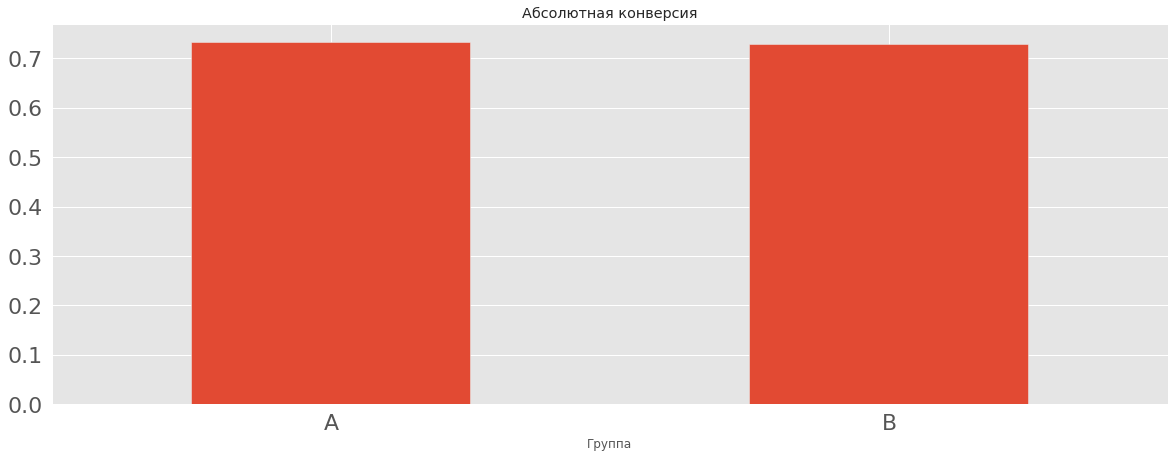

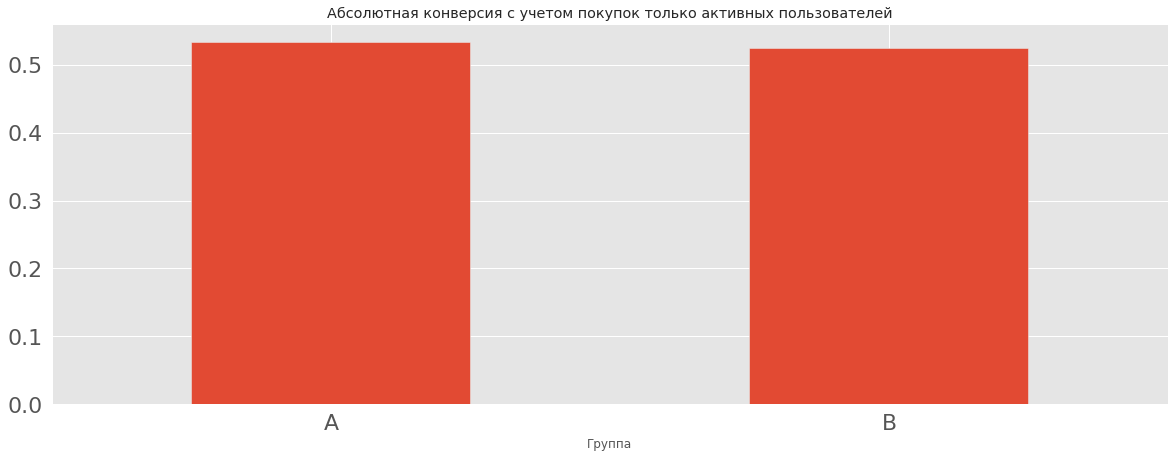

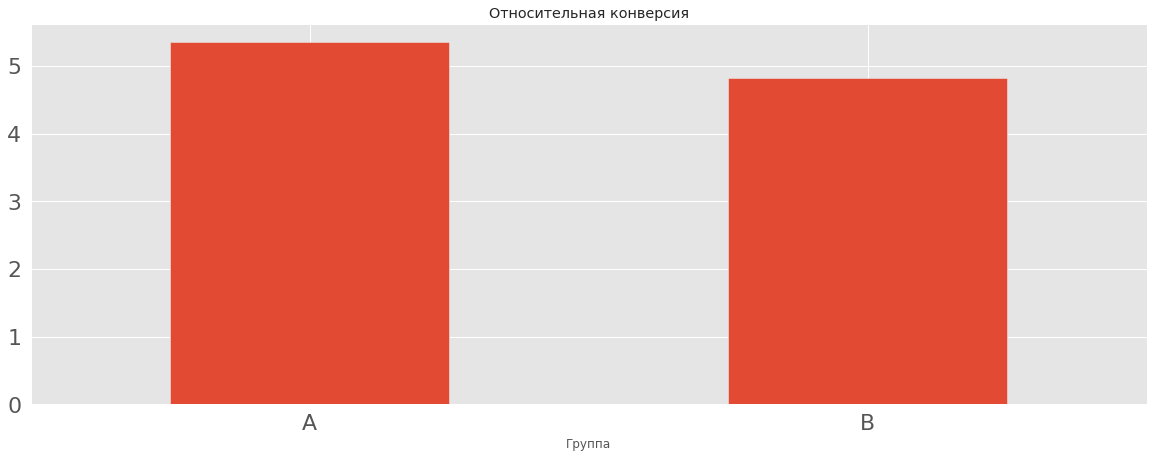

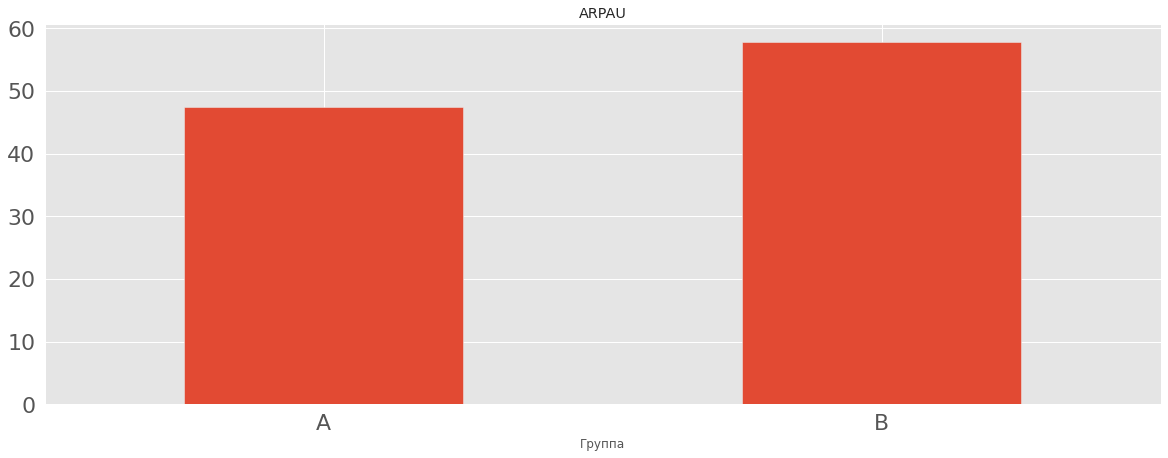

In [65]:
get_metrics(CR_abs, CR_abs_active, CR_relative, ARPAU)